Notebook to generate a fiducial compact object population using a mixture of powerlaws and gaussian. We then allow random pairing and pairing using a powerlaw mixture in q. The parameters are choosen to qualitatively agree with GWTC3 and arXiv: 2109.12119v1.

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import emcee
from scipy.stats import norm, powerlaw

Lets create the initial mass distribution of compact objects.

$p(m) \propto \vec{f_g} \frac{1}{\sqrt{2\pi\vec{\sigma_g}}} \exp [-\frac{(m-\vec{\mu_g})^2}{2\vec{\sigma_g}^2}] + \vec{f_p} H(m-\vec{m}_{min})H(\vec{m}_{max}-m) \frac{\vec{\gamma_p}+1}{\vec{m}_{max}^{\vec{\gamma_p}+1} - \vec{m}_{min}^{\vec{\gamma_p}+1}} m^{\vec{\gamma_p}} $

In [2]:
f_g = np.array([12,3,10]) # gaussian mixture weights
mu = np.array([1.33,1.9,35]) # mean 
sigma = np.array([0.2,0.1,4]) # standard deviation
f_p = np.array([60,30]) # powerlaw mixture weights
m_min = np.array([7.0, 100]) # mass lower bound for power law
m_max = np.array([80.0, 200]) # mass upper bound for power law
gamma = np.array([-1.1, -2]) # power law index


In [3]:
n = np.sum(f_g) + np.sum(f_p)
f_g = f_g/n
f_p = f_p/n


In [4]:
def p_m(m, f_g, mu, sigma, f_p, m_min, m_max, gamma):
     return np.sum(np.array([f_g[i] * norm.pdf(m, loc=mu[i], scale=sigma[i]) for i in range(len(f_g))]),axis=0) \
      + np.sum(np.array([np.heaviside(m-m_min[i],1) * np.heaviside(m_max[i]-m,1) * f_p[i] * (gamma[i]+1) \
      * m**gamma[i]/(m_max[i]**(gamma[i]+1) - m_min[i]**(gamma[i]+1)) for i in range(len(f_p))]), axis=0)

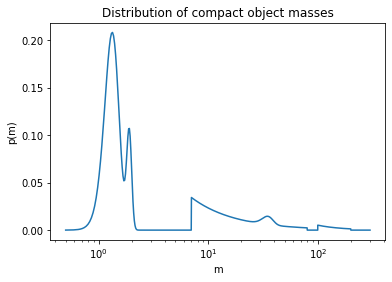

In [5]:
#Plot p(m, f, mu, sigma, m_min, m_max, gamma)
m = np.linspace(.5, 300, 10000)
plt.semilogx(m, p_m(m, f_g, mu, sigma, f_p, m_min, m_max, gamma))
plt.xlabel('m')
plt.ylabel('p(m)')
plt.title('Distribution of compact object masses')
plt.show()


In [6]:
np.trapz(p_m(m, f_g, mu, sigma, f_p, m_min, m_max, gamma), m) # integral of p(m) to check normalization

0.9995739408161646

Now lets set up a code to sample this distribution

In [7]:
#Sample from p_m by emcee
def log_p(m, f_g, mu, sigma, f_p, m_min, m_max, gamma):
    if m < 0 or m > m_max[-1]:
        return -np.inf
    return np.log(p_m(m, f_g, mu, sigma, f_p, m_min, m_max, gamma)+1e-300) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 1 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f_g, mu, sigma, f_p, m_min, m_max, gamma])
p0 = np.random.rand(nwalkers, ndim)*m_max[-1] # initial guess for walkers

state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:23<00:00, 425.65it/s]


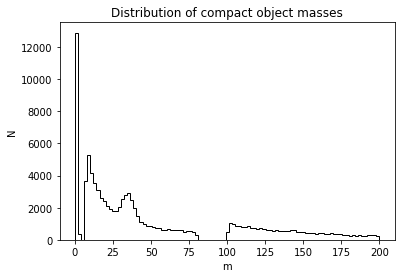

In [8]:
plt.hist(samples[:, 0], bins=np.linspace(0,m_max[-1],100),  color="k", histtype="step");
plt.xlabel('m')
plt.ylabel('N')
plt.title('Distribution of compact object masses')
plt.show()

Now lets impose random pairing.

$p(m1,m2)\propto H(m1-m2)p(m1)p(m2)$

In [9]:
def log_p_m1m2(m1, m2, f_g, mu, sigma, f_p, m_min, m_max, gamma):
    return np.log(1e-300+np.heaviside(m1-m2,1) * p_m(m1, f_g, mu, sigma, f_p, m_min, m_max, gamma) * p_m(m2, f_g, mu, sigma, f_p, m_min, m_max, gamma))

Text(0.5, 1.0, 'Random Pairing')

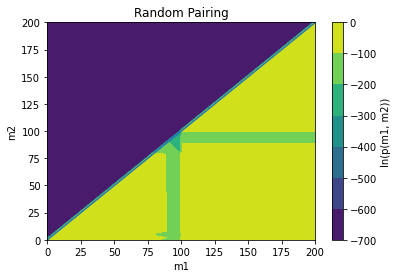

In [10]:
#Plot log_p_m1m2
l = 100
m1 = np.linspace(0.1, m_max[-1], l) * np.ones((l,l))
m2 = (np.linspace(0.1, m_max[-1], l) * np.ones((l,l))).T
plt.contourf(log_p_m1m2(m1, m2, f_g, mu, sigma, f_p, m_min, m_max, gamma), extent=[0,m_max[-1],0,m_max[-1]])
plt.plot(np.linspace(0.1, m_max[-1], l),np.linspace(0.1, m_max[-1], l))
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar(label='ln(p(m1, m2))')
plt.title('Random Pairing')

Now lets sample the distribution

In [11]:
def log_p(m, f_g, mu, sigma, f_p, m_min, m_max, gamma):
    if m[0] < 0 or m[0] > m_max[-1] or m[1] < 0 or m[1] > m_max[-1]:
        return -np.inf
    return log_p_m1m2(m[0], m[1], f_g, mu, sigma, f_p, m_min, m_max, gamma) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 2 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f_g, mu, sigma, f_p, m_min, m_max, gamma])
p0 = np.random.rand(nwalkers, ndim)*m_max[-1]
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:38<00:00, 261.91it/s]


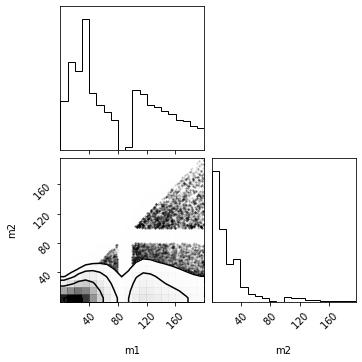

In [12]:
m1_samples, m2_samples = samples.T
 
tr=corner.corner(samples,labels=['m1','m2'],smooth=1.2,color = 'k',title_kwargs={"fontsize": 12},use_math_text=True,hist_kwargs={"density": True})
axes = np.array(tr.axes).reshape((ndim, ndim))

Text(0.5, 1.0, 'Random Pairing')

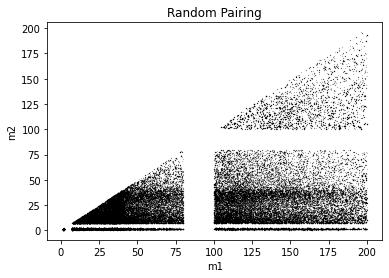

In [13]:
plt.scatter(m1_samples, m2_samples, s=.01, c='k')
plt.xlabel('m1')
plt.ylabel('m2')
plt.title('Random Pairing')

In [14]:
n_BNS = len(m1_samples[np.logical_and(m1_samples < 3, m2_samples < 3)])
n_NSBH = len(m1_samples[np.logical_and(m1_samples > 3, m2_samples < 3)])
n_BBH = len(m1_samples[np.logical_and(m1_samples > 3, m2_samples > 3)])
print('Fraction of BNS: ', n_BNS/(n_BNS+n_NSBH+n_BBH))
print('Fraction of NSBH: ', n_NSBH/(n_BNS+n_NSBH+n_BBH))
print('Fraction of BBH: ', n_BBH/(n_BNS+n_NSBH+n_BBH))


Fraction of BNS:  0.01891
Fraction of NSBH:  0.21998
Fraction of BBH:  0.76111


Now lets introduce a coupling function $\Pi$ 

$\Pi(q) = \vec{f}_q H(q-\vec{q}_{min}) H(\vec{q}_{max}-q) q^{\vec{\gamma}_{q}} \frac{\vec{\gamma}_{q}+1}{\vec{q}_{max}^{\vec{\gamma}_{q}+1} - \vec{q}_{min}^{\vec{\gamma}_{q}+1}}$

In [15]:
def Pi(q, f_q, q_min, q_max, gamma_q):
    return np.array(np.sum([f_q[i]*np.heaviside(q-q_min[i],1)*np.heaviside(q_max[i]-q,1)*q**gamma_q[i] \
        * (gamma_q[i]+1)/(q_max[i]**(gamma_q[i]+1)-q_min[i]**(gamma_q[i]+1)) for i in range(len(f_q))],axis = 0))
    
def log_p_m1m2_w_q(m1, m2, f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q):
    return np.log(1e-300+np.heaviside(m1-m2,1) * Pi(m2/m1, f_q, q_min, q_max, gamma_q)* p_m(m1, f_g, mu, sigma, f_p, m_min, m_max, gamma) * p_m(m2, f_g, mu, sigma, f_p, m_min, m_max, gamma))

In [16]:
f_q = np.array([0.5, 0.5])
q_min = np.array([0.15, 0.7])
q_max = np.array([0.69, 1])
gamma_q = np.array([1, 3])
f_q = f_q/np.sum(f_q)


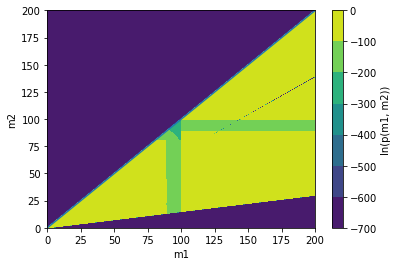

In [17]:
#Plot log_p_m1m2_w_q(m1, m2, f, mu, sigma, m_min, m_max, gamma, fp, q1, q2, q3, gamma_p1, gamma_p2)
l = 1000
m1 = np.linspace(0.1, m_max[-1], l) * np.ones((l,l))
m2 = (np.linspace(0.1, m_max[-1], l) * np.ones((l,l))).T
#log_p_m1m2_w_q(m1, m2, f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q)
plt.contourf(log_p_m1m2_w_q(m1, m2, f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q), extent=[0,m_max[-1],0,m_max[-1]])
plt.plot(np.linspace(0.1, m_max[-1], l),np.linspace(0.1, m_max[-1], l))
plt.xlabel('m1')
plt.ylabel('m2')
plt.colorbar(label='ln(p(m1, m2))')

Now let's sample the distribution

In [18]:
def log_p(m, f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q):
    if m[0] < 0 or m[0] > m_max[-1] or m[1] < 0 or m[1] > m_max[-1]:
        return -np.inf
    return log_p_m1m2_w_q(m[0], m[1], f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q) 

nsamples = 10000 # number of samples
nwalkers = 10 # number of walkers
ndim = 2 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[f_g, mu, sigma, f_p, m_min, m_max, gamma, f_q, q_min, q_max, gamma_q])
p0 = np.random.rand(nwalkers, ndim)*m_max
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)


100%|██████████| 10000/10000 [00:42<00:00, 234.65it/s]


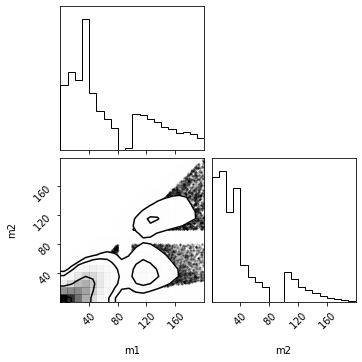

In [19]:
m1_samples, m2_samples = samples.T
 
tr=corner.corner(samples,labels=['m1','m2'],smooth=1.2,color = 'k',title_kwargs={"fontsize": 12},use_math_text=True,hist_kwargs={"density": True})
axes = np.array(tr.axes).reshape((ndim, ndim))

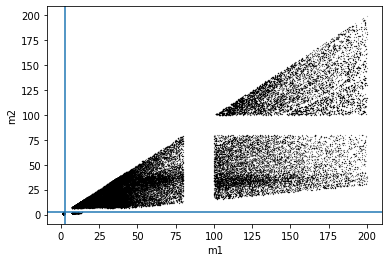

In [20]:
plt.scatter(m1_samples, m2_samples, s=.01, c='k')
plt.xlabel('m1')
plt.ylabel('m2')
plt.axhline(y=3)
plt.axvline(x=3)

In [21]:
n_BNS = len(m1_samples[np.logical_and(m1_samples < 3, m2_samples < 3)])
n_NSBH = len(m1_samples[np.logical_and(m1_samples > 3, m2_samples < 3)])
n_BBH = len(m1_samples[np.logical_and(m1_samples > 3, m2_samples > 3)])
print('Fraction of BNS: ', n_BNS/(n_BNS+n_NSBH+n_BBH))
print('Fraction of NSBH: ', n_NSBH/(n_BNS+n_NSBH+n_BBH))
print('Fraction of BBH: ', n_BBH/(n_BNS+n_NSBH+n_BBH))



Fraction of BNS:  0.04791
Fraction of NSBH:  0.01437
Fraction of BBH:  0.93772


Text(0.5, 0, 'q')

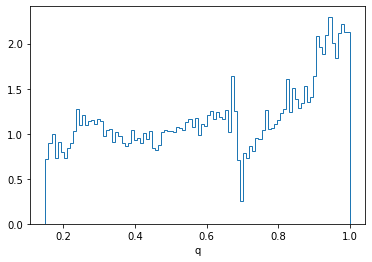

In [22]:
plt.hist(m2_samples/m1_samples, bins=100, density=True, histtype='step');
plt.xlabel('q')

Text(0.5, 0, 'M')

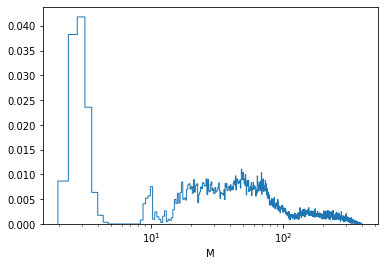

In [23]:
plt.hist(m2_samples+m1_samples, bins=1000, density=True, histtype='step');
plt.semilogx()
plt.xlabel('M')